In [2]:
import numpy as np
from scipy import linalg
from scipy.stats import uniform, multivariate_normal, reciprocal, norm
import os
import healpy as hp
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

In [3]:
def get_param_dict(par_names, pars):
    X = zip(par_names, pars)
    return dict(X)

## Cosmological Parameters

In [4]:
c = 299792.458 # km/s

# Cosmological parameters
Om0 = 0.315
h = 0.738
sigma80 = 0.622

## Covariance Matrix

Here we construct a covariance matrix for the Tully-Fisher relationship.

In [110]:
def get_cov(a, sig1, sig2):
    v1 = np.array([1,a])/np.sqrt(1+a**2)
    v2 = np.array([a,-1]) / 1/np.sqrt(1+a**2)
    O = np.column_stack((v1,v2))
    D = np.diag([sig1**2, sig2**2])
    return np.matmul(O, np.matmul(D, O.T))

# TF parameters from Springob et al.:
a_TF = -7.85 #(10)
b_TF = -20.85 #(2)
WBAR = 10 ** 2.213
MBAR = a_TF*(np.log10(WBAR)-2.5) + b_TF + 5*np.log10(h)
a = a_TF
b = b_TF #+ 5*np.log10(h)
XBAR = np.log10(WBAR)-2.5
YBAR = a*XBAR + b
SIG1_TF = 0.1
SIG2_TF = 0.02


C_TF = get_cov(a_TF, SIG1_TF, SIG2_TF)
SIG_W = np.sqrt(C_TF[0,0])
SIG_M = np.sqrt(C_TF[1,1])
RHO_TF = C_TF[0,1] / (SIG_W * SIG_M) # correlation coefficient


In [111]:
## Coordinate transformtions (Cartesian and Equatorial)

def _eq_to_cart(ra, dec): 
    ra *= np.pi/180
    dec *= np.pi/180
    
    x = np.cos(ra) * np.cos(dec)
    y = np.sin(ra) * np.cos(dec)
    z = np.sin(dec)
    
    return x, y, z

def _cart_to_eq(x, y, z): 
    ra = np.arctan(y/x)
    dec = np.arcsin(z)
    
    ra *= 180/np.pi
    dec *= 180/np.pi
    
    return ra, dec

## Model peculiar velocities

Load in the file containing positions and redshifts of SFI objects and their respective predicted peculiar velocities (from 2M++ reconstruction).

In [112]:
f1 = open("model_velocity/sfi_predpv_2M++.txt","r")
#SNID IAUC RA_host Dec_host pv[km/s]    comoving_distance[Mpc/h100]   zcmb zHubble

beta_true = 0.43
vext_true = np.array([95.0, -133.0, 4.0]) # cartesian coords, [x,y,z] km/s

RA = []
DEC = []
PV_norm = []
PV = []
VEXT_R = []
zcmb = []
zhubble = []
for line in f1:
    if line[0]!='#':
        ra = float(line.split()[1])
        dec = float(line.split()[2])
        du = _eq_to_cart(ra, dec) #unit direction of galaxy
        vext_r = np.dot(du, vext_true) # bulk flow along the line-of-sight
        
        VEXT_R.append(vext_r)
        RA.append(ra)
        DEC.append(dec)
        PV_norm.append((float(line.split()[3])-vext_r)/beta_true)
        PV.append(float(line.split()[3]))
        zcmb.append(float(line.split()[5]))
        zhubble.append(float(line.split()[6]))

sfi_pred = np.column_stack((RA, DEC, VEXT_R, PV_norm, zcmb, zhubble))

## Sanity Check

Verify that the peculiar velocities are approximately the same as the departure from the Hubble law.

Text(0.5, 1.0, 'PV comparison')

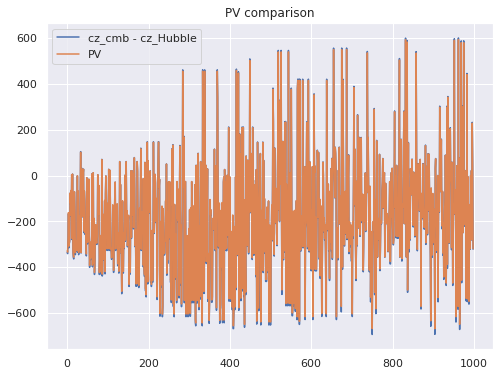

In [113]:
plt.figure(figsize=(8, 6))
plt.plot(c*(np.array(zcmb)-np.array(zhubble)),label='cz_cmb - cz_Hubble')
plt.plot(PV, label='PV')
plt.legend()
plt.title('PV comparison')

[Text(0.5, 0, 'Redshift')]

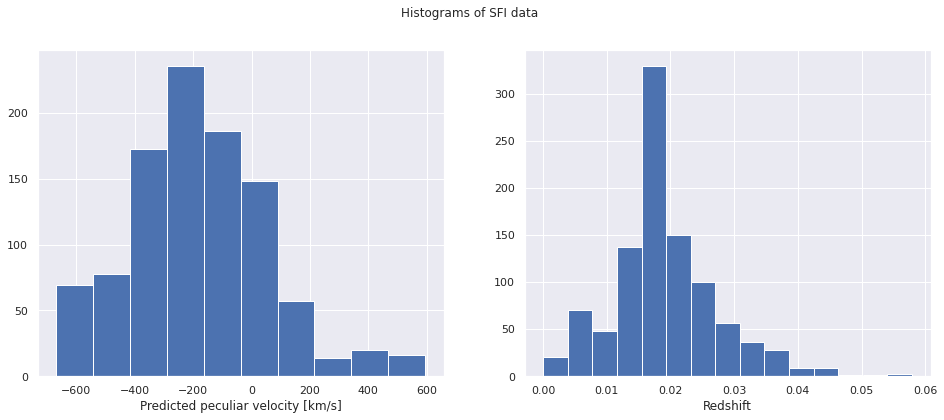

In [114]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Histograms of SFI data')

ax1.hist(np.array(PV), bins=10)
ax1.set(xlabel='Predicted peculiar velocity [km/s]')
ax2.hist(np.array(zcmb), bins=15)
ax2.set(xlabel='Redshift')


## Get random SFI-like samples

In [115]:
def sample_SFI_positions(N=200, save_to_file=False, seed=None):

    data = sfi_pred
    N_SFI = data.shape[0]
    RA = data[:,0] # degrees
    DEC = data[:,1] # degrees
    vext_r = data[:,2]
    PV_norm = data[:,3]
    zcmb = data[:,4]
    #np.random.seed(seed)
    #zcmb = np.random.uniform(low=0.006, high=0.06, size=N_SFI)
    inds = np.random.choice(np.arange(N_SFI), size=N, replace=False)
    print('Sampling SFI angular coordinates')
    RA, DEC, vext_r, PV_norm, zcmb = RA[inds], DEC[inds], vext_r[inds], PV_norm[inds], zcmb[inds]

    return RA, DEC, vext_r, PV_norm, zcmb

# Distance redshift relation

$d_{A}(z) = \bar{d}_{A}(z)(a-\kappa)$

$\kappa(z) = ( 1 - \frac{d_{A}(z)}{\bar{d}_{A}(z)} ) \frac{v}{c} $

In [116]:
class TF_mock:

    def __init__(self, vext=vext_true, beta=beta_true, a=a_TF, wbar=WBAR, xbar=XBAR, mbar=MBAR, ybar=YBAR,sig1=SIG1_TF, sig2=SIG2_TF, seed=None):

        #   Tully Fisher
        self.a = a_TF
        self.wbar = wbar
        self.mbar = mbar
        self.xbar = xbar
        self.ybar = ybar
        self.sig1 = sig1
        self.sig2 = sig2
        
        # Peculiar Velocity
        self.beta = beta
        self.vext = vext
        self.sig11 = 0.04
        self.sig22 = 10
        
        #   Cosmological
        self.Om0 = Om0
        self.Ol0 = 1.0 - self.Om0
        self.h = h
        self.H0 = 100.0 # [h km/s/Mpc]
        self.sigma80 = sigma80
        self.dH = c/self.H0 * 1e3 # c/H_0 [h^-1 kpc]
        self.q0 = 0.5*self.Om0 - self.Ol0

        self.cov_TF = get_cov(self.a, self.sig1, self.sig2)
        #self.mean_TF = np.array([self.wbar, self.mbar])
        self.mean_TF = np.array([self.xbar, self.ybar])
        self.mn = multivariate_normal(mean=self.mean_TF, cov=self.cov_TF)
        self.seed = seed # None is random state

    def E_Hub(self, z):
        """
        Computes E(z) = H(z)/H0
        """
        E2 = self.Om0*(1.+z)**3 + self.Ol0
        if np.all(E2 > 0.0):
            return np.sqrt(E2)
        else:
            return np.NaN
    
    def chi(self, z):
        """
        Computes the comoving distance in units h^-1 kpc using the low-z approximation
        """
        return self.dH * (z - 0.5*(1.+self.q0)*z**2)

    
    def dL(self, z, v=0.0):
        """
        Computes luminosity distance in units h^-1 kpc
        """
        ret = self.chi(z) * (1.+z)
        if v == 0.0:
            ret *= 1.0
        else:
            dA_bar = self.chi(z) / (1.+z)
            dH = self.dH/self.E_Hub(z)
            ret *= 1.0 - (1.0 - dH/dA_bar) * (v/c)
        return ret

    def _get_xy(self, N):

        np.random.seed(self.seed)
        samps = self.mn.rvs(size=N) #shape=(N,3)
        x, y = samps[:,0], samps[:,1]
        return (x, y)
    
    def add_noise_to_y(self, wlatent, w_percentage_err=2.0):
        print('Adding {}% errors to w'.format(w_percentage_err))
        if w_percentage_err == 0.0:
            what = wlatent
            Eyy = np.zeros((what.size))
        else:
            w_err = np.absolute(wlatent * (w_percentage_err/100.0))
            np.random.seed(self.seed)
            dw = np.array([norm.rvs(loc=0, scale=std) for std in w_err])
            what = wlatent + dw
            y_err = w_err
            Eyy = y_err**2
        return what, Eyy
    
    def _get_app_mag(self, M, z, v=0.0):
        dL = np.zeros_like(M)
        for i in range(dL.size):
            dL[i] = self.dL(z[i], v[i])
        mu = 5 * np.log10(dL*1e3*self.h) # convert dL to pc
        return M+mu
    
    def _get_abs_mag(self, m, z, v=0.0):
        dL = np.zeros_like(m)
        for i in range(dL.size):
            dL[i] = self.dL(z[i], v[i])
        mu = 5 * np.log10(dL*1e3*self.h) # convert dL to pc
        return m-mu
        
    def _get_luminosity_distance(self, z, v=0.0):
        chi = np.zeros_like(z)
        for i in range(chi.size):
            chi[i] = self.dL(z[i], v[i])
        return chi
    
    def init_SFI_like_data(self, N=500, add_pv=True, w_percentage_err=0.0, scale=1.0):
        
        np.random.seed(self.seed)
        self.N = N
        self.RA, self.DEC, self.vext_r, self.V_samp_norm, self.zcmb = sample_SFI_positions(self.N, seed=self.seed)
        self.V_samp = self.V_samp_norm*self.beta + self.vext_r
        if add_pv == False:
            self.V_samp = np.zeros(self.N)
        self.alpha = self.RA * np.pi/180
        self.delta = self.DEC * np.pi/180
        x_percentage_err=0.434*w_percentage_err

        print('Generating wm data for {} galaxies...'.format(self.N))
        self.xlatent, self.ylatent = self._get_xy(self.N)
        self.wlatent, self.mlatent = 10**(self.xlatent+2.5), 5*np.log10(self.h) + self.ylatent
        self.what, self.Eyy = self.add_noise_to_y(self.wlatent, w_percentage_err)
        self.xhat, self.Eyy = self.add_noise_to_y(self.xlatent, x_percentage_err)

        self.ztot = (1.0 + self.zcmb) * (1.0 + self.V_samp/c) - 1.0
        self.appmag = self._get_app_mag(self.mlatent, self.ztot, self.V_samp)
        self.absmag = self.mlatent
        self.lumin_dist = self._get_luminosity_distance(self.ztot, self.V_samp)
        self.co_dist = self.lumin_dist/(1+self.ztot)

    def data_dict(self): 
        return {'z': self.ztot, 'zcmb':self.zcmb, 'vext':self.vext_r, 'dL':self.lumin_dist, 'pv_norm':self.V_samp_norm, 'pv':self.V_samp,'m': self.appmag, 'M':self.absmag, 'w': self.what, 'RA': self.RA, 'DEC': self.DEC, 'Eyy': self.Eyy, 'x': self.xlatent, 'y':self.ylatent, 'r':self.co_dist}

In [117]:
mock = TF_mock(a=a_TF,sig1=SIG1_TF*0.1, sig2=SIG2_TF*0.01)
mock.init_SFI_like_data(N=500, w_percentage_err = 2)

mock_no_pv = TF_mock(a=a_TF,sig1=SIG1_TF*0.1, sig2=SIG2_TF*0.01)
mock_no_pv.init_SFI_like_data(N=500, w_percentage_err=2, add_pv=False)

Sampling SFI angular coordinates
Generating wm data for 500 galaxies...
Adding 2% errors to w
Adding 0.868% errors to w
Sampling SFI angular coordinates
Generating wm data for 500 galaxies...
Adding 2% errors to w
Adding 0.868% errors to w


<ipython-input-116-6a8ac384f8b9>:90: RuntimeWarning: invalid value encountered in log10
  mu = 5 * np.log10(dL*1e3*self.h) # convert dL to pc


## These are things we actually measure (observables)

$\eta \equiv \log(2v_{rot}) - 2.5$

$W \equiv 2v_{rot}$

[Text(0.5, 0, '$\\eta$')]

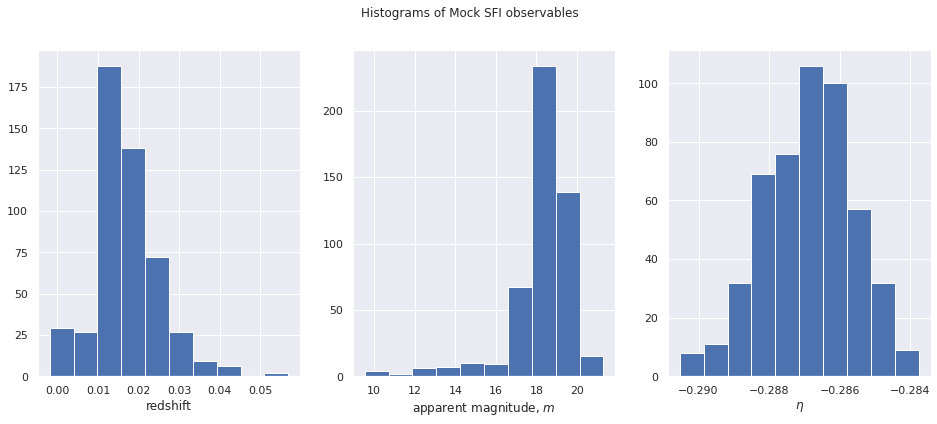

In [128]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))
fig.suptitle('Histograms of Mock SFI observables')

ax1.hist(mock.data_dict()['z'], bins=10)
ax1.set(xlabel='redshift')
ax2.hist(mock.data_dict()['m'])
ax2.set(xlabel='apparent magnitude, $m$')
ax3.hist((mock.data_dict()['x']))
ax3.set(xlabel='$\eta$')

absolute magnitude
$M(\eta) = a - b\eta$

$ M = m + \log{r} $

## Tully-Fisher relationship of the mock

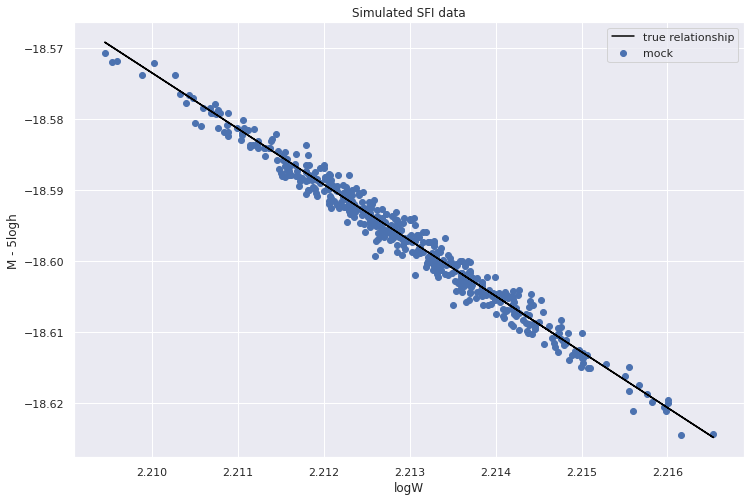

In [25]:
plt.figure(figsize=(12, 8))
plt.scatter(mock.data_dict()['x']+2.5,mock.data_dict()['y'],label='mock')
#plt.scatter(mock_no_pv.data_dict()['x']+2.5,mock_no_pv.data_dict()['y'], label='No peculiar velocities')
plt.plot(mock.data_dict()['x']+2.5, mock.data_dict()['x']*a_TF+b_TF , label='true relationship',color='black')
plt.xlabel('logW')
plt.ylabel('M - 5logh')
plt.title('Simulated SFI data')
plt.legend()

## Departure from Hubble's law due to peculiar velocities (mock)

Text(0.5, 1.0, 'Mock SFI data -- Recessional velocity vs distance')

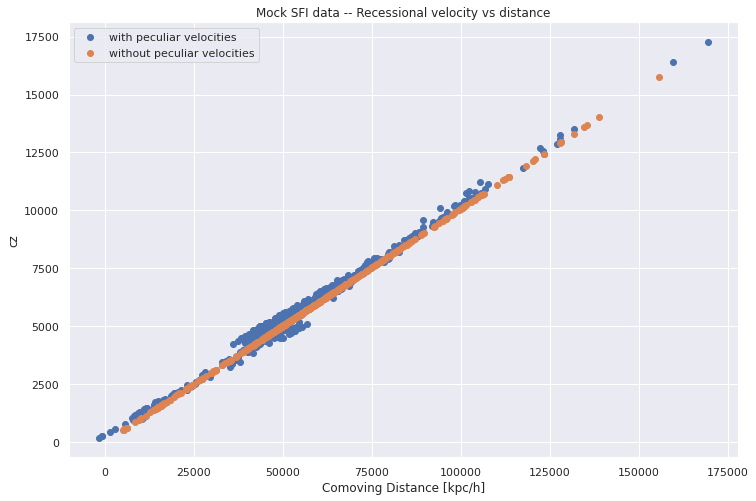

In [118]:
plt.figure(figsize=(12, 8))
plt.scatter( mock.data_dict()['r'], c*mock.data_dict()['z'], label='with peculiar velocities')
plt.scatter(mock_no_pv.data_dict()['r'], c*mock_no_pv.data_dict()['z'],  label='without peculiar velocities')
plt.legend()
plt.ylabel('cz')
plt.xlabel('Comoving Distance [kpc/h]')
plt.title('Mock SFI data -- Recessional velocity vs distance')

<ipython-input-104-5e37f23a7454>:2: RuntimeWarning: invalid value encountered in log10
  app_mag = 5*np.log10(mock.data_dict()['dL']*1e3*h)+mock.data_dict()['y']+5*np.log10(h)


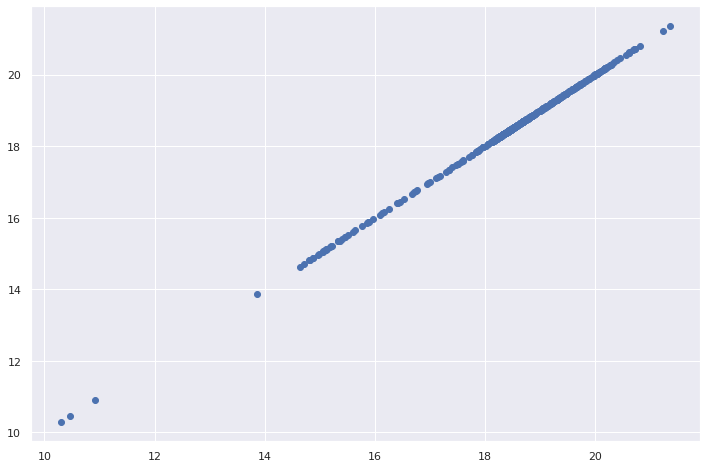

In [104]:
plt.figure(figsize=(12, 8))
app_mag = 5*np.log10(mock.data_dict()['dL']*1e3*h)+mock.data_dict()['y']+5*np.log10(h)
plt.scatter( mock.data_dict()['m'], app_mag)

## where did the extra factor of 10 come from?

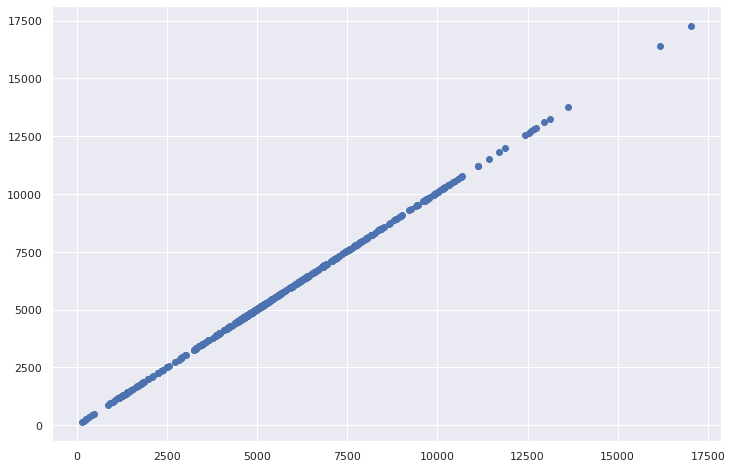

In [105]:
plt.figure(figsize=(12, 8))
plt.scatter( mock.data_dict()['r']/10-(mock.data_dict()['pv_norm']*beta_true+mock.data_dict()['vext']), c*mock.data_dict()['z']) #km/s

Intrinsic scatter of peculiar velocities:
$ \sigma_{v} = 150 \textrm{ km/s} $

Combined error in the TF forward model (scatter in the $r$ direction) and in the observed apparent magnitude:
$ \sigma_{TF}^{2} = \sigma_{r}^{2} + \epsilon_{m}^{2}$


In [161]:
m = mock.data_dict()['m']

finite_inds = np.where(np.isfinite(m))[0]

m = mock.data_dict()['m'][finite_inds]
z = mock.data_dict()['z'][finite_inds]
x = mock.data_dict()['x'][finite_inds]
yerr = mock.data_dict()['Eyy'][finite_inds]
pred = mock.data_dict()['pv'][finite_inds]
ra = mock.data_dict()['RA'][finite_inds]
dec = mock.data_dict()['DEC'][finite_inds]

sigma_v = 150 # km/s from Carrick et al.

r = mock.data_dict()['r'][finite_inds]
r_range = r

The joint probability:
$P(\eta,m,cz,\mathbf{r}) = \frac{1}{\sqrt{2\pi}\sigma_{TF}} \exp \left[ -\frac{[m - (M(\eta)+\mu(r))]^{2}}{2\sigma^{2}_{TF}} \right] 
\frac{1}{\sqrt{2\pi}\sigma_{v}} \exp \left[ -\frac{(cz - [r+u(\mathbf{r})])^{2}}{2\sigma^{2}_{v}} \right] r^{2} (1+\delta_{g}(\mathbf{r})).$

The log-likelihood:
$\textrm{ln} \mathcal{L} = -\frac{1}{2} \sum_{n=1}^{N_{g}} \frac{1}{S_{n}} \left[ \frac{[m - (M(\eta)+\mu(r))]^{2}}{\sigma^{2}_{TF}} + \textrm{ln}(\sigma^{2}_{TF}) \right.
  \left. + \frac{(cz - [r+u(\mathbf{r})])^{2}}{\sigma^{2}_{v}}+ \textrm{ln}(\sigma^{2}_{v}) - 2 \textrm{ln}(r^{2}(1+\delta_{g}(\mathbf{r}))) \right]_{n}$

In [162]:
def log_likelihood_TF(theta, x, m, z, yerr, ra, dec):
    a, b, sigma_r, beta, vext_x, vext_y, vext_z = theta
    sigma2 = yerr ** 2 + sigma_r ** 2
    
    ret = 0
    
    for r_samp in r_range:
        model = 5*np.log10(np.absolute(r_samp*1e3*h)) + b + (a*x)+5*np.log10(h)
        ret+= -0.5 * np.sum((m - model) ** 2 / sigma2 + np.log(sigma2))

    #model = 5*np.log10(np.absolute(r*1e3*h)) + b + (a*x)+5*np.log10(h)
    #sigma2 = yerr ** 2 + sigma_r ** 2
    
    #return -0.5 * np.sum((m - model) ** 2 / sigma2 + np.log(sigma2))
    
    return ret/len(r_range)

def log_likelihood_PV(theta, x, m, z, yerr, ra, dec):
    a, b, sigma_r, beta, vext_x, vext_y, vext_z = theta
    du = np.array(_eq_to_cart(ra, dec)).T #unit direction of galaxy
    vext_r = np.dot(du, [vext_x, vext_y, vext_z])
    sigma2 = sigma_v ** 2
    pv = beta*pred + vext_r
    ret = 0
    
    for r_samp in r_range:
        model = r_samp/10 - pv
        ret+= -0.5 * np.sum((c*z - model) ** 2 / sigma2 + np.log(sigma2))

    #model = r/10 - pv
    #sigma2 = sigma_v ** 2
    #return -0.5 * np.sum((c*z - model) ** 2 / sigma2 + np.log(sigma2))
    
    return ret/len(r_range)

def log_prior(theta):
    a, b, sigma_r, beta, vext_x, vext_y, vext_z = theta
    if -50.0 < a < 50.0 and -50.0 < b < 50.0 and 0 < beta < 2.0 and -50.0 < sigma_r < 50.0: #and 0 < r < 200000 
        return 0.0
    return -np.inf

def log_probability(theta, x, m, z, yerr, ra, dec):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_TF(theta, x, m, z, yerr, ra, dec) + log_likelihood_PV(theta, x, m, z, yerr, ra, dec)


In [155]:
def log_likelihood_ML(theta, x, m, z, yerr, ra, dec):
    a, b, sigma_r, beta, vext_x, vext_y, vext_z = theta
    
    model = 5*np.log10(np.absolute(r*1e3*h)) + b + (a*x)+5*np.log10(h)
    sigma2 = yerr ** 2 + sigma_r ** 2
    l1 = -0.5 * np.sum((m - model) ** 2 / sigma2 + np.log(sigma2))
    
    du = np.array(_eq_to_cart(ra, dec)).T #unit direction of galaxy
    vext_r = np.dot(du, [vext_x, vext_y, vext_z])
    pv = beta*pred + vext_r
    model_PV = r/10 - pv
    sigma2_PV = sigma_v ** 2
    l2 = -0.5 * np.sum((c*z - model_PV) ** 2 / sigma2_PV + np.log(sigma2_PV))
    
    return l1 + l2


In [156]:
from scipy.optimize import minimize

true_params = np.array([a_TF, b_TF, 0.1, beta_true, vext_true[0], vext_true[1], vext_true[2]])

np.random.seed(42)
nll = lambda *args: -log_likelihood_ML(*args)
initial = true_params + 0.1 * np.random.randn(7)
soln = minimize(nll, initial, args=(x, m, z, yerr, ra, dec))
a_ml, b_ml, sigma_ml, beta_ml, vext_x_ml, vext_y_ml, vext_z_ml = soln.x

In [157]:
a_ml, b_ml, sigma_ml, beta_ml, vext_x_ml, vext_y_ml, vext_z_ml

(-7.800328584698876,
 -20.86382643011712,
 0.16476885381006925,
 0.5823029856408025,
 94.97658466252767,
 -133.02341369569493,
 4.157921281550739)

In [ ]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 7)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, m, z, yerr, ra, dec))
sampler.run_mcmc(pos, 5000, progress=True);

In [145]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))


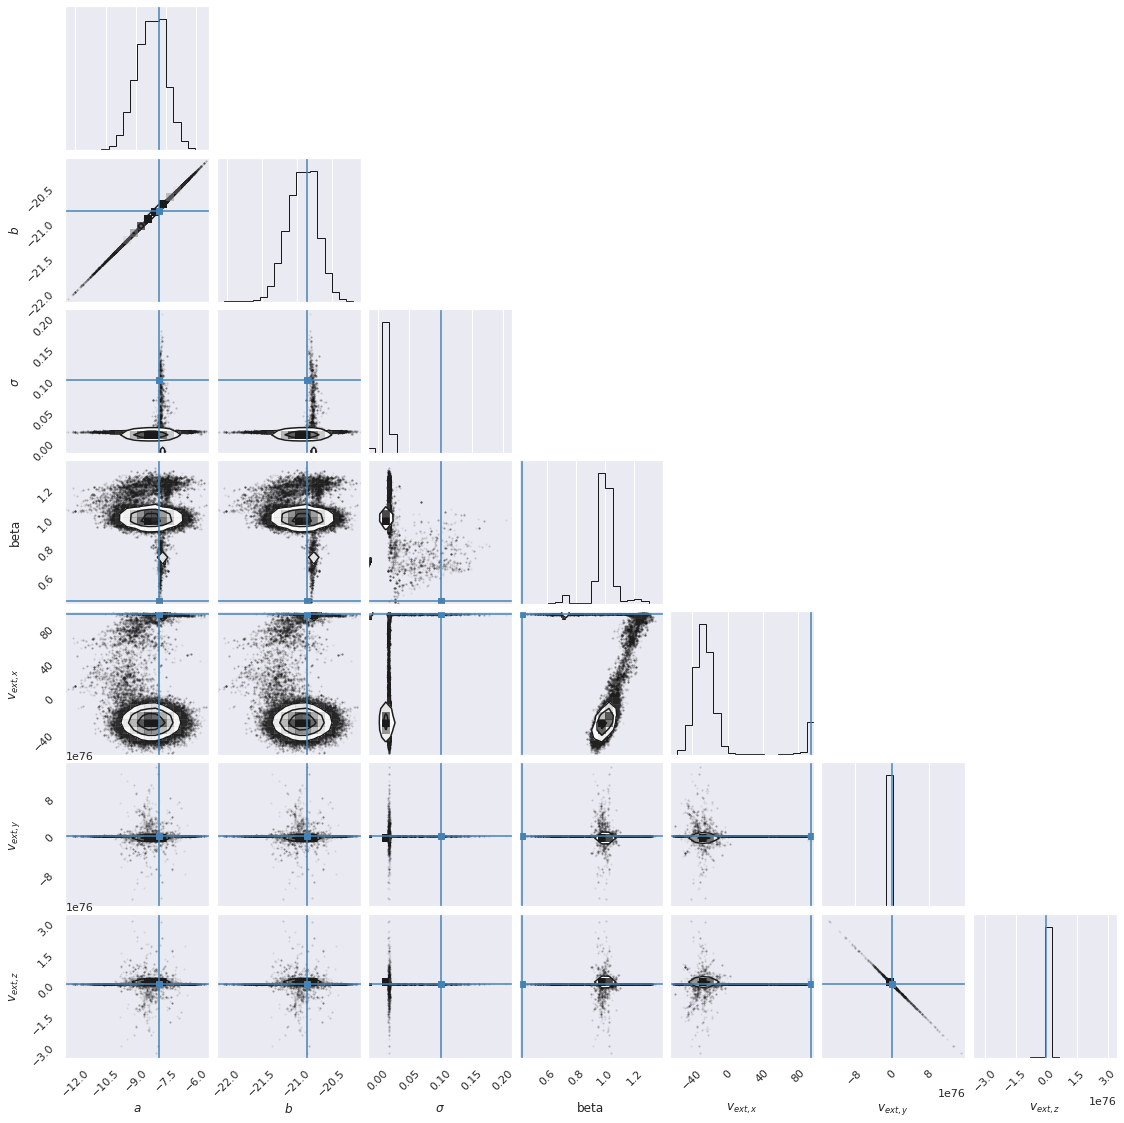

In [146]:
import corner
fig = corner.corner(samples, labels=["$a$", "$b$", "$\sigma$", "beta", "$v_{ext, x}$",  "$v_{ext, y}$",  "$v_{ext, z}$"], truths=true_params)
plt.show()

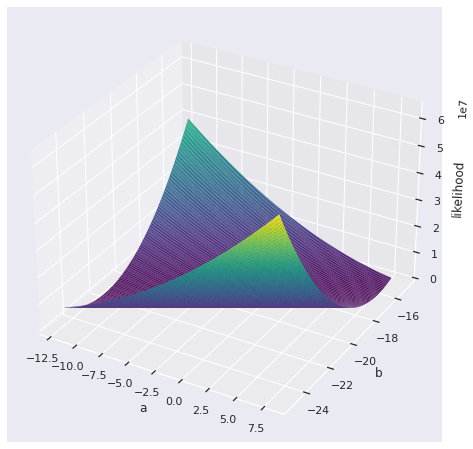

In [129]:
true_params = np.array([a_TF, b_TF, 0.1, beta_true, vext_true[0], vext_true[1], vext_true[2]])

b_range = np.arange(-25,-15,0.1)
a_range = np.arange(-12,8,0.1)
likelihood = np.zeros((b_range.shape[0], a_range.shape[0]))

for i in range(len(b_range)):
    b_samp = b_range[i]
    p_range = [[a_samp, b_samp, sigma_ml, beta_ml, vext_x_ml, vext_y_ml, vext_z_ml] for a_samp in a_range]
    likelihood[i] = [-log_likelihood_TF(theta, x, m, z, yerr, ra, dec) for theta in p_range] 

X, Y = np.meshgrid(a_range, b_range)
Z = likelihood
    
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z,rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('likelihood');

#plt.plot(a_range, b_range,likelihood)
#plt.title('Negative Log Likelihood for Simulated TF data')
#plt.xlabel('a')

Text(0.5, 0, 'a')

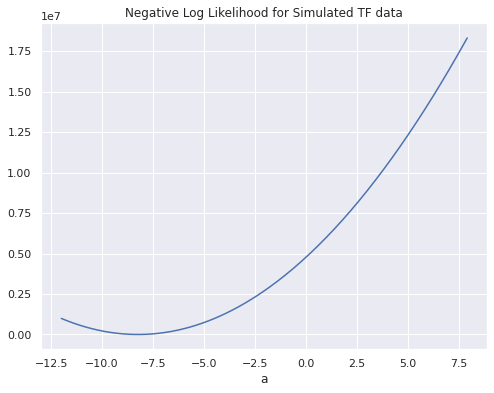

In [130]:
plt.figure(figsize=(8, 6))
p_range = [[a_samp, b_ml, sigma_ml, beta_ml, vext_x_ml, vext_y_ml, vext_z_ml] for a_samp in a_range]
likelihood = [-log_likelihood_TF(theta, x, m, z, yerr, ra, dec) for theta in p_range] 

plt.plot(a_range,likelihood)
plt.title('Negative Log Likelihood for Simulated TF data')
plt.xlabel('a')


Text(0.5, 0, 'b')

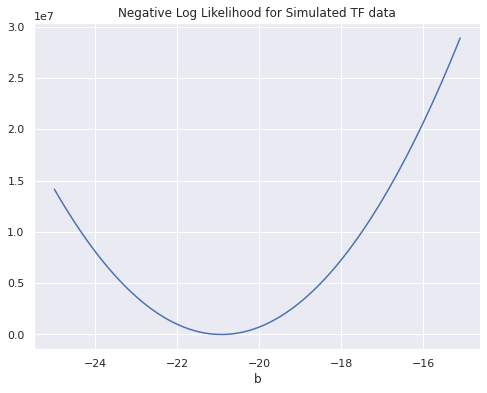

In [131]:
plt.figure(figsize=(8, 6))
p_range = [[a_ml, b_samp, sigma_ml, beta_ml, vext_x_ml, vext_y_ml, vext_z_ml] for b_samp in b_range]
likelihood = [-log_likelihood_TF(theta, x, m, z, yerr, ra, dec) for theta in p_range] 

plt.plot(b_range,likelihood)
plt.title('Negative Log Likelihood for Simulated TF data')
plt.xlabel('b')


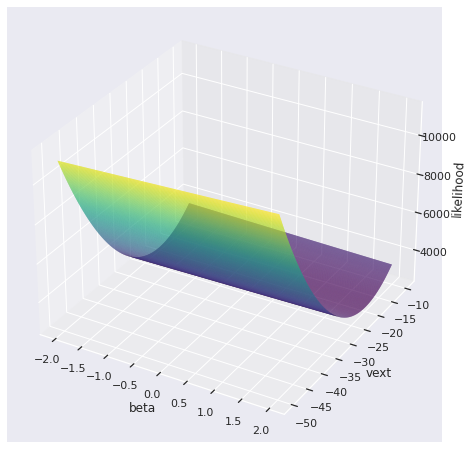

In [74]:
true_params = np.array([a_TF, b_TF, 0.1, 1.0, 0.0])

beta_range = np.arange(-2,2,0.01)
vext_range = np.arange(-50,-10,0.1)
likelihood = np.zeros((beta_range.shape[0], vext_range.shape[0]))

for i in range(len(beta_range)):
    beta_samp = beta_range[i]
    p_range = [[a_TF, b_TF, sigma_ml, beta_samp, vext_samp] for vext_samp in vext_range]
    likelihood[i] = [-log_likelihood_PV(theta, x, m, z, yerr) for theta in p_range] 

X, Y = np.meshgrid(beta_range, vext_range)
Z = likelihood
    
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z,rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('beta')
ax.set_ylabel('vext')
ax.set_zlabel('likelihood');

#plt.plot(a_range, b_range,likelihood)
#plt.title('Negative Log Likelihood for Simulated TF data')
#plt.xlabel('a')

Text(0.5, 0, 'beta')

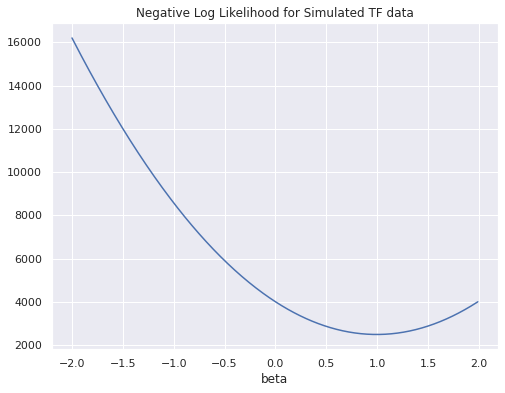

In [119]:
plt.figure(figsize=(8, 6))
p_range = [[a_ml, b_ml, sigma_ml, beta_samp, vext_ml] for beta_samp in beta_range]
likelihood = [-log_likelihood_PV(theta, x, m, z, yerr) for theta in p_range] 

plt.plot(beta_range,likelihood)
plt.title('Negative Log Likelihood for Simulated TF data')
plt.xlabel('beta')


Text(0.5, 0, 'vext')

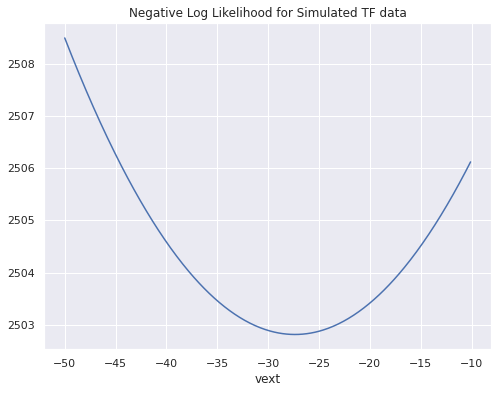

In [73]:
plt.figure(figsize=(8, 6))
p_range = [[a_ml, b_ml, sigma_ml, beta_ml, vext_samp] for vext_samp in vext_range]
likelihood = [-log_likelihood_PV(theta, x, m, z, yerr) for theta in p_range] 

plt.plot(vext_range,likelihood)
plt.title('Negative Log Likelihood for Simulated TF data')
plt.xlabel('vext')